In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import WeightedRandomSampler

from triagerx.dataset.processor import DatasetProcessor
from triagerx.model.lbt_p import LBTPClassifier
from triagerx.model.roberta_cnn import RobertaCNNClassifier
from triagerx.model.roberta_fcn import RobertaFCNClassifier
from triagerx.trainer.model_trainer import ModelTrainer
from triagerx.trainer.train_config import TrainConfig


In [123]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/gc_20_topics_kmeans.csv"

In [125]:
df = pd.read_csv(dataset_path)
df = df[df["owner"].notna()]

def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df.apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            + "\nDescription: "
            + str(x["description"]),
            axis=1,
        )
    
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    # df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

df = prepare_dataframe(df)
df = clean_data(df)

num_issues = len(df)

print(f"Total number of issues: {num_issues}")

/tmp/ipykernel_2419987/3790925874.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')


Total number of issues: 109977


array(['Touch and Scroll Issues', 'Security and SSL issues',
       'Webpage rendering regression issues',
       'Chrome Tab and Window Behavior Issues',
       'WebRTC audio/video issues', 'Chrome stability issues',
       'Layout Testing Issues', 'Build failures', 'Chrome sync issues',
       'GPU rendering issues', 'Memory Leaks in WebCore and Blink',
       'Data Enhancement', 'DevTools Crashes',
       'Input and keyboard issues', 'Performance Regression in Blink',
       'Shill WiFi configuration',
       'Performance testing issues in Chromium', 'Chrome crash reports',
       'Bookmark issues', 'iOS File Issues'], dtype=object)

In [131]:
topic_ids = {
    label: idx for idx, label in enumerate(df.topic_label.unique())
}

In [132]:
topic_ids

{'Touch and Scroll Issues': 0,
 'Security and SSL issues': 1,
 'Webpage rendering regression issues': 2,
 'Chrome Tab and Window Behavior Issues': 3,
 'WebRTC audio/video issues': 4,
 'Chrome stability issues': 5,
 'Layout Testing Issues': 6,
 'Build failures': 7,
 'Chrome sync issues': 8,
 'GPU rendering issues': 9,
 'Memory Leaks in WebCore and Blink': 10,
 'Data Enhancement': 11,
 'DevTools Crashes': 12,
 'Input and keyboard issues': 13,
 'Performance Regression in Blink': 14,
 'Shill WiFi configuration': 15,
 'Performance testing issues in Chromium': 16,
 'Chrome crash reports': 17,
 'Bookmark issues': 18,
 'iOS File Issues': 19}

In [133]:
df["topic_id"] =df["topic_label"].apply(lambda label: topic_ids[label])

In [139]:
from sklearn.preprocessing import OneHotEncoder

In [141]:
df["topic_id"]

0          0
1          1
2          2
3          3
4          0
          ..
109972    16
109973    10
109974    12
109975     9
109976    13
Name: topic_id, Length: 109977, dtype: int64

In [150]:
df["topic_hot"] = pd.get_dummies(df["topic_label"]).values.tolist()

In [151]:
df[df.owner == "aa@chromium.org"]

,Unnamed: 0,owner,issue_title,description,topic_id,topic_label,text,topic_hot
88,88,aa@chromium.org,popup-blocker is broken after r104975,Several pyauto tests for popup-blocker started...,3,Chrome Tab and Window Behavior Issues,Title: popup-blocker is broken after r104975\n...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
129,129,aa@chromium.org,REGRESSION: Extension label font extremely small.,Chrome Version : 6.0.476.0 (53570)URLs (...,2,Webpage rendering regression issues,Title: REGRESSION: Extension label font extrem...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
390,390,aa@chromium.org,CSS rules from extensions being over written b...,Chrome Version : 6.0.472.4 dev (mac)URLs...,2,Webpage rendering regression issues,Title: CSS rules from extensions being over wr...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
605,605,aa@chromium.org,Allow extensions from web store to use experim...,This will allow us to whitelist extensions to ...,5,Chrome stability issues,Title: Allow extensions from web store to use ...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
607,607,aa@chromium.org,Remove toolstrip parsing code from extension.cc,Remove toolstrip parsing code from extension.cc,5,Chrome stability issues,Title: Remove toolstrip parsing code from exte...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
88728,88730,aa@chromium.org,Move html_viewer to services,mojo/examples/html_viewer -> mojo/services/blink,5,Chrome stability issues,Title: Move html_viewer to services\nDescripti...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
92060,92062,aa@chromium.org,Google Mail Checker: Turns grey/questionmarky ...,"matt, can you look at this?",3,Chrome Tab and Window Behavior Issues,Title: Google Mail Checker: Turns grey/questio...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
92070,92072,aa@chromium.org,Google Mail Checker: Does not show counts grea...,I recently added this explicitly because I not...,3,Chrome Tab and Window Behavior Issues,Title: Google Mail Checker: Does not show coun...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
92602,92604,aa@chromium.org,Regression: browserAction.onclicked requires t...,This was apparently not the case in the past.,5,Chrome stability issues,Title: Regression: browserAction.onclicked req...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [152]:
num_cv = 10
sample_threshold=20
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

block = 1
X_df = df[:samples_per_block*block]
y_df = df[samples_per_block*block : samples_per_block * (block+1)]


developers = X_df["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
X_df = X_df[X_df["owner"].isin(filtered_developers)]

train_owners = set(X_df["owner"])
test_owners = set(y_df["owner"])

unwanted = list(test_owners - train_owners)

y_df = y_df[~y_df["owner"].isin(unwanted)]

print(f"Training data: {len(X_df)}, Validation data: {len(y_df)}")

Samples per block: 10998
Training data: 7030, Validation data: 6096


In [153]:
lbl2idx = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx

In [154]:
X_df["owner_id"] = X_df["owner"].apply(lambda owner: lbl2idx[owner])
y_df["owner_id"] = y_df["owner"].apply(lambda owner: lbl2idx[owner])

In [155]:
class CombineLoss(nn.Module):
    def __init__(self, class_weights) -> None:
        super().__init__()
        self._ce = nn.CrossEntropyLoss(weight=class_weights)

    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)
            # print(loss)

        return loss

In [156]:
import torch
import torch.nn.functional as F
from torch import nn
from transformers import RobertaModel, RobertaTokenizer


class LBTPClassifierTopic(nn.Module):
    def __init__(
        self, output_size, unfrozen_layers=4, embed_size=1024, dropout=0.1
    ) -> None:
        super().__init__()
        model_name = "roberta-large"
        self.base_model = RobertaModel.from_pretrained(
            model_name, output_hidden_states=True
        )
        self._tokenizer = RobertaTokenizer.from_pretrained(model_name)

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till last {unfrozen_layers} layers
        for i in range(0, 24 - unfrozen_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = 512
        self._embed_size = embed_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, embed_size)),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(
                    len(filter_sizes) * self._num_filters + embed_size, output_size
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, topic_id):
        outputs = []

        base_out = self.base_model(input_ids, attention_mask=attention_mask)
        pooler_out = base_out.pooler_output.squeeze(0)
        hidden_states = base_out.hidden_states[-self.unfrozen_layers :]

        for i in range(self.unfrozen_layers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]
            x = torch.cat(x, dim=1)
            x = torch.cat([pooler_out, x], dim=1)
            x = self.dropout(x)
            x = torch.cat([x, topic_id], dim=1)
            x = self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self) -> RobertaTokenizer:
        return self._tokenizer


In [157]:
model = LBTPClassifierTopic(
    output_size=len(X_df.owner_id.unique())
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [158]:
class_counts = np.bincount(X_df["owner_id"])
num_samples = sum(class_counts)
labels = X_df["owner_id"].to_list() #corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [159]:
from sklearn.utils.class_weight import compute_class_weight

In [160]:
class_weights = compute_class_weight('balanced', classes=X_df["owner_id"].unique(), y=X_df["owner_id"].to_numpy())

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [161]:
learning_rate = 1e-5
epochs = 15
batch_size = 15

In [13]:
sampler_name = sampler.__class__.__name__ if sampler else "None"
model_name = model.__class__.__name__

output_file = f"dt_lbtp_cv{block}_weighted_ce_{model_name}_20_{sampler_name}"
output_path = f"/home/mdafifal.mamun/notebooks/triagerX/output/{output_file}.pt"

wandb_config = {
        "project": "triagerx_dt_cv",
        "name": f"run_{output_file}",
        "config": {
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "deeptriage",
        "epochs": epochs,
    }
}

criterion = CombineLoss(class_weights_tensor)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=10, factor=0.1, threshold=1e-8)

train_config = TrainConfig(
    optimizer=optimizer,
    criterion=criterion,
    train_dataset=X_df,
    validation_dataset=y_df,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    output_file=output_path,
    sampler=sampler,
    scheduler=scheduler,
    wandb=wandb_config
)

In [16]:
trainer = ModelTrainer(train_config)
trainer.train(model=model)

2024-02-17 15:56:13.782 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-02-17 15:56:13.784 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-02-17 15:56:24.922 | DEBUG    | triagerx.dataset.triage_dataset:__init__:17 - Generating torch dataset...
2024-02-17 15:56:24.926 | DEBUG    | triagerx.dataset.triage_dataset:__init__:20 - Tokenizing texts...
2024-02-17 15:56:33.890 | DEBUG    | triagerx.trainer.model_trainer:train:33 - Initializing wandb...
wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


2024-02-17 15:56:43.419 | DEBUG    | triagerx.trainer.model_trainer:train:48 - Selected compute device: cuda
  0%|          | 0/469 [00:00<?, ?it/s]/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 469/469 [04:18<00:00,  1.81it/s]
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2024-02-17 16:03:39.571 | INFO     | triagerx.trainer.model_trainer:_log_step:173 - Epochs: 1 | Train Loss:  1.330           

KeyboardInterrupt: 

In [14]:
model.load_state_dict(torch.load(output_path))

<All keys matched successfully>

In [15]:
import pandas as pd
import numpy as np
from loguru import logger
from torch.utils.data import Dataset

from transformers import PreTrainedTokenizer


class SimilarityDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        feature: str = "text",
        target: str = "owner_id",
    ):
        logger.debug("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        logger.debug("Tokenizing texts...")
        self.texts = [
            [row.issue_title, self.tokenizer(
                row[feature],
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )]
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [16]:
from torch.utils.data import DataLoader
from triagerx.dataset.triage_dataset import TriageDataset

dataset = SimilarityDataset(y_df, model.tokenizer())

2024-02-20 10:40:45.399 | DEBUG    | __main__:__init__:17 - Generating torch dataset...
2024-02-20 10:40:45.401 | DEBUG    | __main__:__init__:20 - Tokenizing texts...


In [17]:
len(y_df)

6095

In [18]:
cuda = torch.cuda.is_available()

if cuda:
    model = model.cuda()

tokenizer = model.tokenizer()

In [19]:
# triage_dataset = TriageDataset(y_df, model.tokenizer())
loader = DataLoader(dataset, 30)

In [20]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [21]:
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

In [58]:
similarity_df = X_df.copy()

In [46]:
similarity_threshold = 50

In [48]:
sim_developers = similarity_df["owner"].value_counts()
filtered_developers = sim_developers.index[sim_developers <= similarity_threshold]
similarity_df = similarity_df[similarity_df["owner"].isin(filtered_developers)]

In [59]:
similarity_df.owner.value_counts()

jon@chromium.org              300
sky@chromium.org              182
davidjames@chromium.org       176
sosa@chromium.org             124
ananta@chromium.org           114
                             ... 
rsleevi@chromium.org           20
atwilson@chromium.org          20
dennisjeffrey@chromium.org     20
nduca@chromium.org             20
bleung@chromium.org            20
Name: owner, Length: 168, dtype: int64

In [60]:
len(filtered_developers)

131

In [61]:
all_embeddings = similarity_model.encode(similarity_df.issue_title.to_list(), batch_size=15)

In [62]:
def get_top_k_similar_devs(issues, k=5):
    test_embed = similarity_model.encode(issues)
    cos = util.cos_sim(test_embed, all_embeddings)
    topk = torch.topk(torch.tensor(cos), k=k)
    
    similarities = []
    
    for it in topk.indices.numpy():
        # print(X_df.iloc[it]["owner_id"])
        similarities.append(X_df.iloc[it]["owner_id"].unique().tolist())

    return similarities

In [63]:
# torch.set_printoptions(sci_mode=True)

In [64]:
total_acc_val = 0
total_loss_val = 0
correct_top_k = 0
correct_top_k_wo_sim = 0

all_preds = []
all_labels = []
device="cuda"

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input[1]["attention_mask"].to(device)
        input_id = val_input[1]["input_ids"].squeeze(1).to(device)

        output = model(input_id, mask)



        output = torch.sum(torch.stack(output), 0)

        #wo similarity
        _, top_k_wo_sim = output.topk(10, 1, True, True)

        top_k_wo_sim = top_k_wo_sim.t()

        correct_top_k_wo_sim += (
            top_k_wo_sim.eq(
                val_label.view(1, -1).expand_as(top_k_wo_sim)
            )
            .sum()
            .item()
        )


        # with similarity
        _, top_k_predictions = output.topk(10, 1, True, True)
        similar_preds = get_top_k_similar_devs(val_input[0], k=5)

        unique_preds = []

        for top, sim in zip(top_k_predictions, similar_preds):
            # print(top, sim)
            
            copy_pred = top.cpu().numpy().tolist()
            top_preds = top.cpu().numpy().tolist()[:5]

            for s in sim:
                if s not in top_preds:
                    top_preds.append(s)
            
            if len(top_preds) < 10:
                top_preds = top_preds + copy_pred[5:5 + 10 - len(top_preds)]
            
            unique_preds.append(top_preds)

        unique_preds = torch.tensor(unique_preds).cuda()
        top_k_predictions = unique_preds.t()

        correct_top_k += (
            top_k_predictions.eq(
                val_label.view(1, -1).expand_as(top_k_predictions)
            )
            .sum()
            .item()
        )

        # break

        acc = (output.argmax(dim=1) == val_label).sum().item()

        all_preds.append(output.argmax(dim=1).cpu().numpy())
        all_labels.append(val_label.cpu().numpy())

        total_acc_val += acc

/tmp/ipykernel_2419987/1405196658.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos), k=k)


In [65]:
print(f"Correct Prediction without Similarity: {correct_top_k_wo_sim}, {correct_top_k_wo_sim / len(y_df)}")
print(f"Correct Prediction with Similarity: {correct_top_k} {correct_top_k / len(y_df)}")

Correct Prediction without Similarity: 4107, 0.67383100902379
Correct Prediction with Similarity: 4250 0.6972928630024611


In [66]:
all_preds_np = np.concatenate(all_preds)
all_labels_np = np.concatenate(all_labels)

In [93]:
idx2label = {
    row["owner_id"]: row["owner"]
    for _, row in y_df.iterrows()
}

labels = y_df.owner_id.to_list()
labels = sorted(set(labels))
labels = [f"{idx}: {idx2label[idx]}" for idx in labels]

In [97]:
from sklearn.metrics import classification_report

In [98]:
from sklearn.metrics import classification_report
print(classification_report(all_labels_np, all_preds_np, target_names=labels))

                                precision    recall  f1-score   support

          0: a...@chromium.org       0.11      0.08      0.10        61
            1: aa@chromium.org       0.00      0.00      0.00        50
        2: abarth@chromium.org       0.19      0.15      0.16        48
       3: achuith@chromium.org       0.00      0.00      0.00        10
          4: adlr@chromium.org       0.77      0.77      0.77        98
           5: agl@chromium.org       0.17      0.09      0.12        56
        6: akalin@chromium.org       0.05      0.05      0.05        20
    7: altimofeev@chromium.org       0.07      0.25      0.11         4
          8: amit@chromium.org       0.27      0.57      0.36         7
        9: ananta@chromium.org       0.17      0.18      0.18        56
      10: annapop@chromium.org       0.49      0.71      0.58        48
     11: apatrick@chromium.org       0.33      0.33      0.33        21
      12: apavlov@chromium.org       0.54      0.49      0.52  

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [104]:
X_df[X_df.owner == "aa@chromium.org"]

,owner,issue_title,description,text,owner_id
88,aa@chromium.org,popup-blocker is broken after r104975,\nSeveral pyauto tests for popup-blocker start...,Title: popup-blocker is broken after r104975\n...,1
129,aa@chromium.org,REGRESSION: Extension label font extremely small.,\nChrome Version : 6.0.476.0 (53570)\r\n...,Title: REGRESSION: Extension label font extrem...,1
390,aa@chromium.org,CSS rules from extensions being over written b...,\nChrome Version : 6.0.472.4 dev (mac)\r...,Title: CSS rules from extensions being over wr...,1
605,aa@chromium.org,Allow extensions from web store to use experim...,\nThis will allow us to whitelist extensions t...,Title: Allow extensions from web store to use ...,1
607,aa@chromium.org,Remove toolstrip parsing code from extension.cc,\nRemove toolstrip parsing code from extension...,Title: Remove toolstrip parsing code from exte...,1
609,aa@chromium.org,No error reported for normal extensions reques...,\nIt seems like we should report errors in thi...,Title: No error reported for normal extensions...,1
1075,aa@chromium.org,Allow extensions from the store to access expe...,\nWe will trust the store to restrict access t...,Title: Allow extensions from the store to acce...,1
1529,aa@chromium.org,remove --enable-apps from beta branch,\nGiven that beta and stable will be lagging (...,Title: remove --enable-apps from beta branch\n...,1
1972,aa@chromium.org,REGRESSION: extensions unable to access local ...,\nI've traced this down to r55103:\r\n http:/...,Title: REGRESSION: extensions unable to access...,1
2235,aa@chromium.org,Remove Gears,\nChrome Version : 5.0.375.125\r\n\r\nGe...,Title: Remove Gears\nDescription: \nChrome Ver...,1


In [105]:
for pred, label in zip(all_preds_np, all_labels_np):
    print(pred, label)

166 117
2 2
118 140
114 25
27 151
117 9
23 23
157 70
65 65
4 4
162 22
2 64
151 91
24 68
116 49
4 4
91 25
56 54
55 139
109 94
113 82
49 145
113 113
34 34
146 146
4 4
4 4
14 1
133 41
49 58
141 52
33 41
77 23
150 24
125 139
18 18
50 18
137 65
163 154
130 139
109 165
151 95
113 155
4 4
73 28
113 155
125 65
65 1
153 122
4 4
159 21
125 139
48 157
123 123
131 56
141 133
60 60
157 5
42 167
10 10
162 162
130 49
91 127
65 65
157 2
49 68
49 49
49 45
79 5
84 58
127 127
127 127
65 65
125 137
114 72
68 27
49 139
137 137
65 9
142 35
67 77
114 114
130 77
37 77
11 134
114 5
114 114
78 47
122 122
55 139
49 150
101 37
102 147
125 0
98 56
116 137
55 55
130 0
133 111
125 137
133 97
0 147
150 77
139 17
162 162
49 150
122 122
143 47
49 17
69 6
109 109
163 163
108 108
47 81
124 165
106 81
128 93
40 4
141 141
139 139
9 51
146 150
9 9
116 2
80 75
14 53
26 6
7 58
6 76
133 133
125 21
133 141
46 46
113 155
17 116
5 53
36 77
114 163
130 100
24 24
141 72
77 151
115 35
118 5
33 39
125 74
27 65
40 40
106 148
107 66
86

In [71]:
all_labels_np[:5], all_preds_np[:5]

(array([117,   2, 140,  25, 151]), array([166,   2, 118, 114,  27]))

KeyboardInterrupt: 

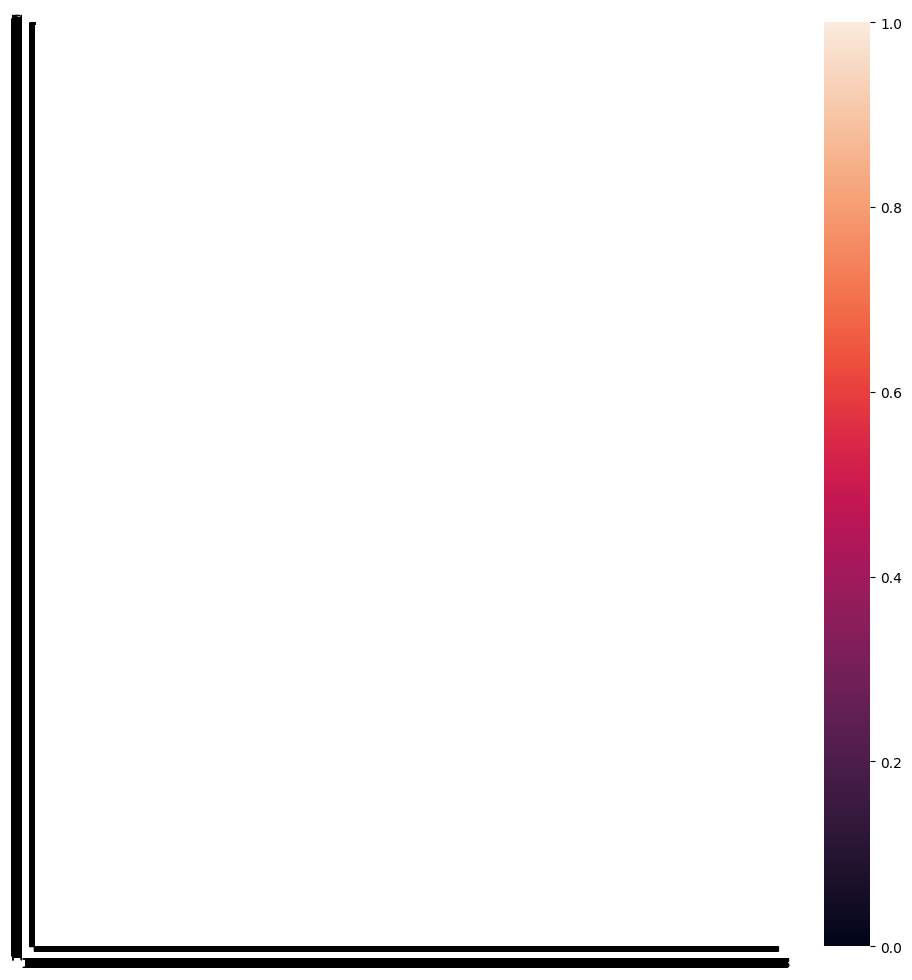

In [74]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(confusion_matrix(all_labels_np[:10], all_preds_np[:10]), xticklabels=labels, yticklabels=labels, ax=ax)

plt.show()